In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pandas as pd
import numpy as np
import cv2

from tensorflow.keras.preprocessing.image import img_to_array

import keras
from keras.utils import to_categorical 
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense




import keras.backend as K


Using TensorFlow backend.


Preparing the dataset for the images

In [3]:
# path /content/drive/My Drive/crop_part1

file_names = os.listdir("/content/drive/My Drive/crop_part1")
len(file_names)

9780

In [4]:
# parameters
inputshape = (100,100,3)
epochs = 100
batch_size = 64

In [5]:
pixels = []
gender = []
for i in file_names:

  # format [age]_[gender]_[race]_[date&time].jpg
  nameformat = (i.split("_"))
  imggender = nameformat[1]
  if imggender == "3":  # to remove the invalid entry
    continue
  gender.append(imggender)

  image = cv2.imread(os.path.join("/content/drive/My Drive/crop_part1",i))
  image = cv2.resize(image,(inputshape[0], inputshape[1]))
  image = img_to_array(image)
  pixels.append(image)



In [6]:
set(gender)

{'0', '1'}

In [7]:
pixels = np.array(pixels, dtype="float") / 255.0
gender = np.array(gender)

gender = to_categorical(gender,num_classes=2)

In [8]:
pixels.shape , gender.shape

((9779, 100, 100, 3), (9779, 2))

In [9]:
# split the data for train and test
from sklearn.model_selection import train_test_split
(trainX, testX, trainY, testY) = train_test_split(pixels, gender, test_size=0.2,
                                                  random_state=42)

Preparation of data for the model

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

Defining Model for the gender classification

In [11]:
def define_model(width, height, depth, classes = 4):
  model = Sequential()
  inputShape = (height, width, depth)
  chanDim = -1

  if K.image_data_format() == "channels_first": #Returns a string, either 'channels_first' or 'channels_last'
        inputShape = (depth, height, width)
        chanDim = 1

  model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=chanDim))
  model.add(MaxPooling2D(pool_size=(3,3)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3,3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=chanDim))

  model.add(Conv2D(64, (3,3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=chanDim))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, (3,3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=chanDim))

  model.add(Conv2D(128, (3,3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=chanDim))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(1024))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(classes))
  model.add(Activation("sigmoid"))

  return model

  

In [12]:
model = define_model(width=inputshape[0], height=inputshape[1], depth=inputshape[2],
                            classes=2)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 33, 33, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 33, 33, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 33, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 33, 33, 64)        0

In [13]:
from tensorflow.keras.optimizers import Adam
lr = 1e-3
opt = Adam(lr=lr, decay=lr/epochs)
model.compile(optimizer=opt, loss = "binary_crossentropy", metrics = ["accuracy"])

In [14]:
history = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
                        validation_data=(testX,testY),
                        steps_per_epoch=len(trainX) // batch_size,
                        epochs=epochs, verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
122/122 [==============================] - 19s 152ms/step - loss: 0.7836 - accuracy: 0.6529 - val_loss: 2.3904 - val_accuracy: 0.5475
Epoch 2/100
122/122 [==============================] - 18s 148ms/step - loss: 0.6537 - accuracy: 0.6895 - val_loss: 0.8569 - val_accuracy: 0.4703
Epoch 3/100
122/122 [==============================] - 18s 147ms/step - loss: 0.5880 - accuracy: 0.7176 - val_loss: 0.6034 - val_accuracy: 0.7132
Epoch 4/100
122/122 [==============================] - 18s 148ms/step - loss: 0.5444 - accuracy: 0.7305 - val_loss: 0.5003 - val_accuracy: 0.7469
Epoch 5/100
122/122 [==============================] - 18s 148ms/step - loss: 0.5223 - accuracy: 0.7373 - val_loss: 0.4918 - val_accuracy: 0.7454
Epoch 6/100
122/122 [==============================] - 18s 149ms/step - loss: 0.4983 - accuracy: 0.7547 - val_loss: 0.4791 - val_accuracy: 0.7623
Epoch 7/100
122/122 [===========================

In [25]:
model.save("/content/drive/My Drive/gender_detection_model.model")

INFO:tensorflow:Assets written to: /content/drive/My Drive/gender_detection_model.model/assets


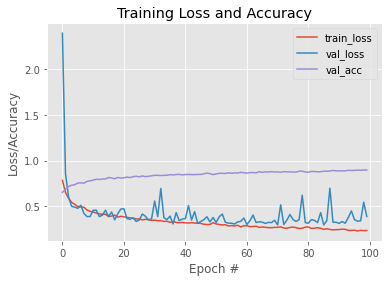

In [24]:
from matplotlib import pyplot as plt
# plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0,N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0,N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,N), history.history["accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

plt.show()